In [1]:
using BenchmarkTools
using Plots
include("funciones_de_red.jl")
include("objetos.jl")
include("dinamica_conductores.jl")

BPR (generic function with 3 methods)

## Random and square graphs

In [2]:
n=200
RandNet, position_array_Rand, weight_matrix_Rand = mySimpleGraph(n);

In [3]:
k = 20
SquareNet, position_array_Square, weight_matrix_Square = SquareDiGraph(k);
#gplot(SquareNet, nodelabel=1:k^2)

## Benchmarking A* vs Dijkstra

A* search evaluates what next step to take by combining the cost to reach the node $g(n)$ and an estimation of the cost to get from that node to the destination $h(n)$.

So it calculates a function $f(n) = g(n) + h(n)$ and proceeds to move to the node that minimizes it.

$h(n)$ will include memory of the drivers

In [4]:
origin_sq = rand(1:k^2)
destination_sq = rand(1:k^2)
println("$origin_sq - $destination_sq")

251 - 301


In [5]:
origin_rand = rand(1:n)
destination_rand = rand(1:n)
println("$origin_rand - $destination_rand")

69 - 110


#### Dijkstra is just A* with heuristic $h(n) = 0$

In [6]:
LightGraphs.a_star(SquareNet,origin_sq,destination_sq,weight_matrix_Square)

13-element Array{LightGraphs.SimpleGraphs.SimpleEdge{Int64},1}:
 Edge 251 => 250
 Edge 250 => 249
 Edge 249 => 248
 Edge 248 => 247
 Edge 247 => 246
 Edge 246 => 266
 Edge 266 => 286
 Edge 286 => 285
 Edge 285 => 284
 Edge 284 => 304
 Edge 304 => 303
 Edge 303 => 302
 Edge 302 => 301

In [7]:
@belapsed LightGraphs.a_star(SquareNet,origin_sq,destination_sq, weight_matrix_Square)

0.000563429

In [8]:
LightGraphs.a_star(RandNet,origin_rand,destination_rand,weight_matrix_Rand)

4-element Array{LightGraphs.SimpleGraphs.SimpleEdge{Int64},1}:
 Edge 69 => 58
 Edge 58 => 175
 Edge 175 => 133
 Edge 133 => 110

In [9]:
@belapsed LightGraphs.a_star(RandNet,origin_rand,destination_rand,weight_matrix_Rand)

0.000627761

#### To use A* we need to define an heuristic function

In [10]:
LightGraphs.a_star(SquareNet,origin_sq, destination_sq,weight_matrix_Square,
    n -> EuclideanHeuristic(n,destination_sq,position_array_Square))

13-element Array{LightGraphs.SimpleGraphs.SimpleEdge{Int64},1}:
 Edge 251 => 250
 Edge 250 => 249
 Edge 249 => 248
 Edge 248 => 247
 Edge 247 => 246
 Edge 246 => 245
 Edge 245 => 244
 Edge 244 => 264
 Edge 264 => 263
 Edge 263 => 283
 Edge 283 => 282
 Edge 282 => 302
 Edge 302 => 301

In [11]:
k = @belapsed LightGraphs.a_star(SquareNet,origin_sq,destination_sq,weight_matrix_Square,
    n -> EuclideanHeuristic(n,destination_sq,position_array_Square))

0.000147175

In [12]:
k

0.000147175

In [13]:
LightGraphs.a_star(RandNet,origin_rand, destination_rand,weight_matrix_Rand,
    n -> EuclideanHeuristic(n,destination_rand,position_array_Rand))

4-element Array{LightGraphs.SimpleGraphs.SimpleEdge{Int64},1}:
 Edge 69 => 58
 Edge 58 => 175
 Edge 175 => 133
 Edge 133 => 110

In [14]:
@belapsed LightGraphs.a_star(RandNet,origin_rand,destination_rand,weight_matrix_Rand,
    n -> EuclideanHeuristic(n,destination_rand,position_array_Rand))

0.00027241

## Time growth function

### Random network

In [15]:
dijkstra_randNet_times = []
for n in 2:100:1000
    origin_rand = rand(1:n);
    destination_rand = rand(1:n);
    RandNet, position_array_Rand, weight_matrix_Rand = mySimpleGraph(n);
    t = @elapsed LightGraphs.a_star(RandNet,origin_rand,destination_rand,weight_matrix_Rand);
    push!(dijkstra_randNet_times,t)
end

In [16]:
as_randNet_times = []
for n in 2:100:1000
    origin_rand = rand(1:n);
    destination_rand = rand(1:n);
    RandNet, position_array_Rand, weight_matrix_Rand = mySimpleGraph(n);
    t = @elapsed LightGraphs.a_star(RandNet,origin_rand,destination_rand,weight_matrix_Rand,
    n -> EuclideanHeuristic(n,destination_rand,position_array_Rand));
    push!(as_randNet_times,t)
end

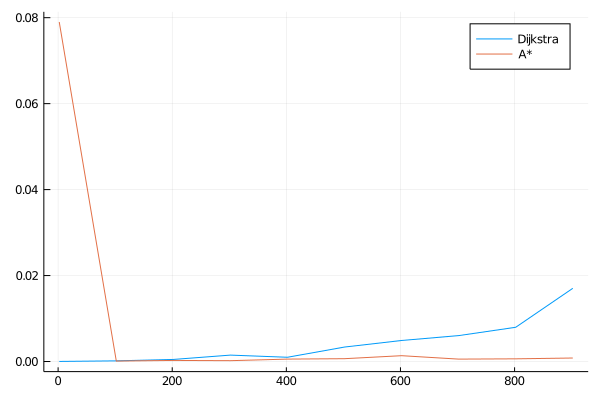

In [17]:
plot(2:100:1000, dijkstra_randNet_times,label="Dijkstra")
plot!(2:100:1000, as_randNet_times, label="A*")

### Square network

In [18]:
dijkstra_SqNet_times = []
for k in 2:20:100
    origin_sq = rand(1:k^2);
    destination_sq = rand(1:k^2);
    SquareNet, position_array_Square, weight_matrix_Square = SquareDiGraph(k);
    t = @belapsed LightGraphs.a_star(SquareNet,origin_sq, destination_sq,weight_matrix_Square);
    push!(dijkstra_SqNet_times,t)
end

In [19]:
as_SqNet_times = []
for k in 2:20:100
    origin_sq = rand(1:k^2);
    destination_sq = rand(1:k^2);
    SquareNet, position_array_Square, weight_matrix_Square = SquareDiGraph(k);
    t = @belapsed LightGraphs.a_star(SquareNet,origin_sq, destination_sq,weight_matrix_Square,
    n -> EuclideanHeuristic(n,destination_sq,position_array_Square));
    push!(as_SqNet_times,t)
end

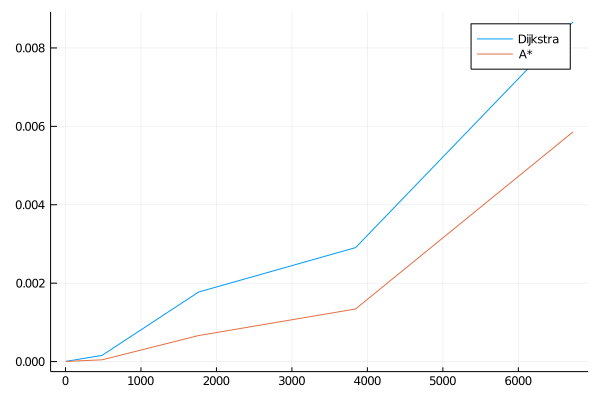

In [20]:
plot((2:20:100).^2, dijkstra_SqNet_times,label="Dijkstra")
plot!((2:20:100).^2, as_SqNet_times, label="A*")

## Understanding A*

In [21]:
# Parts of this code were taken / derived from Graphs.jl. See LICENSE for
# licensing details.

# A* shortest-path algorithm

function reconstruct_path!(total_path, # a vector to be filled with the shortest path
    came_from, # a vector holding the parent of each node in the A* exploration
    end_idx, # the end vertex
    g) # the graph

    E = edgetype(g)
    curr_idx = end_idx
    while came_from[curr_idx] != curr_idx
        pushfirst!(total_path, E(came_from[curr_idx], curr_idx))
        curr_idx = came_from[curr_idx]
    end
end

function a_star_impl!(g, # the graph
    goal, # the end vertex
    open_set, # an initialized heap containing the active vertices
    closed_set, # an (initialized) color-map to indicate status of vertices
    g_score, # a vector holding g scores for each node
    f_score, # a vector holding f scores for each node
    came_from, # a vector holding the parent of each node in the A* exploration
    distmx,
    heuristic)

    E = edgetype(g)
    total_path = Vector{E}()

    @inbounds while !isempty(open_set)
        current = dequeue!(open_set)

        if current == goal
            reconstruct_path!(total_path, came_from, current, g)
            return total_path
        end

        closed_set[current] = true

        for neighbor in LightGraphs.outneighbors(g, current)
            closed_set[neighbor] && continue

            tentative_g_score = g_score[current] + distmx[current, neighbor]

            if tentative_g_score < g_score[neighbor]
                g_score[neighbor] = tentative_g_score
                priority = tentative_g_score + heuristic(neighbor)
                open_set[neighbor] = priority
                came_from[neighbor] = current
            end
        end
    end
    return total_path
end

"""
    a_star(g, s, t[, distmx][, heuristic])
Return a vector of edges comprising the shortest path between vertices `s` and `t`
using the [A* search algorithm](http://en.wikipedia.org/wiki/A%2A_search_algorithm).
An optional heuristic function and edge distance matrix may be supplied. If missing,
the distance matrix is set to [`LightGraphs.DefaultDistance`](@ref) and the heuristic is set to
`n -> 0`.
"""
function a_star(g::AbstractGraph{U},  # the g
    s::Integer,                       # the start vertex
    t::Integer,                       # the end vertex
    distmx::AbstractMatrix{T}=weights(g),
    heuristic::Function=n -> zero(T)) where {T, U}

    E = Edge{eltype(g)}

    # if we do checkbounds here, we can use @inbounds in a_star_impl!
    checkbounds(distmx, Base.OneTo(nv(g)), Base.OneTo(nv(g)))

    open_set = PriorityQueue{Integer, T}()
    enqueue!(open_set, s, 0)

    closed_set = zeros(Bool, nv(g))

    g_score = fill(Inf, nv(g))
    g_score[s] = 0

    f_score = fill(Inf, nv(g))
    f_score[s] = heuristic(s)

    came_from = -ones(Integer, nv(g))
    came_from[s] = s

    a_star_impl!(g, t, open_set, closed_set, g_score, f_score, came_from, distmx, heuristic)
end

a_star

In [22]:
methods(LightGraphs.a_star)

# 3 methods for generic function "a_star":
[1] a_star(g::AbstractGraph{U}, s::Integer, t::Integer) where U in LightGraphs at /Users/Mariana/.julia/packages/LightGraphs/IgJif/src/shortestpaths/astar.jl:67
[2] a_star(g::AbstractGraph{U}, s::Integer, t::Integer, distmx::AbstractArray{T,2}) where {T, U} in LightGraphs at /Users/Mariana/.julia/packages/LightGraphs/IgJif/src/shortestpaths/astar.jl:67
[3] a_star(g::AbstractGraph{U}, s::Integer, t::Integer, distmx::AbstractArray{T,2}, heuristic::Function) where {T, U} in LightGraphs at /Users/Mariana/.julia/packages/LightGraphs/IgJif/src/shortestpaths/astar.jl:67